In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

from movie_metadata_table import MovieMetadataTable

import sys
sys.path.append("../algorithms")
from deepfm import DeepFM # type: ignore

In [3]:
movie_metadata_table = MovieMetadataTable(
    movie_ids_file="../data/movie_ids.json",
    movie_data_vectorized_file="../data/vectorizing/movie_data_vectorized.csv",
    nlp_vectors_file="../data/vectorizing/nlp_vectors.pt",
)

In [4]:
import json
import random

random.seed(8888)

# get movie ids, clipping off movie ids that are not in the movie tensor
all_movie_ids = json.load(open("../data/movie_ids.json"))[:movie_metadata_table.movie_tensor.shape[0]]
movie_metadata_isna = movie_metadata_table.movie_metadata.isna().any(axis=1)
all_movie_ids = [all_movie_ids[i] for i in range(len(all_movie_ids)) if not movie_metadata_isna[i]]
random.shuffle(all_movie_ids)

In [5]:
ratings = pd.read_csv("../data/ratings_export.csv")
ratings = ratings.dropna()

In [47]:
num_movies = 1000

train_movie_ids = all_movie_ids[:num_movies]
test_movie_ids = all_movie_ids[num_movies:num_movies+num_movies//8]

train_ratings = ratings[ratings['movie_id'].isin(train_movie_ids)]
test_ratings = ratings[ratings['movie_id'].isin(test_movie_ids)]

# Identify users who are in both
avail_train_users = set(train_ratings['user_id'].unique())
avail_test_users = set(test_ratings['user_id'].unique())
avail_users = avail_train_users.intersection(avail_test_users)

train_ratings = train_ratings[train_ratings['user_id'].isin(avail_users)]
test_ratings = test_ratings[test_ratings['user_id'].isin(avail_users)]

train_movie_ids_filtered = train_ratings['movie_id'].unique()
test_movie_ids_filtered = test_ratings['movie_id'].unique()

print("Number of available users:", len(avail_users))
print("Number of training movies:", len(train_movie_ids_filtered))
print("Number of testing movies:", len(test_movie_ids_filtered))

device = "cuda" if torch.cuda.is_available() else "cpu"
user_vector_size = 64
user_id_to_index = {user_id: i for i, user_id in enumerate(avail_users)}

Number of available users: 2999
Number of training movies: 968
Number of testing movies: 124


In [48]:
user_embedding_table = nn.Embedding(len(avail_users), user_vector_size).to(device)
deepfm = DeepFM(
    movie_metadata_table.movie_vector_size,
    user_vector_size,
    num_dense_movie_embeddings=8,
    num_dense_user_embeddings=4,
    dense_embedding_size=16,
    mlp_sizes=[16, 16, 1],
).to(device)

In [49]:
print(len(movie_metadata_table.movie_ids), movie_metadata_table.movie_tensor.shape)

285961 torch.Size([270422, 231])


In [50]:
def calculate_accuracy(test_ratings, user_embedding_table, movie_metadata_table, deepfm, user_id_to_index, device):
    """
    Calculates the accuracy of the DeepFM model on the test dataset.
    
    :param test_ratings: DataFrame containing user_id, movie_id, and rating_val.
    :param user_embedding_table: Function to obtain user embeddings by user indices.
    :param movie_metadata_table: Function to obtain movie embeddings by movie slugs.
    :param deepfm: DeepFM model that predicts the probability of a user liking a movie.
    :param user_id_to_index: Dictionary mapping user_id to their respective index.
    :param device: The torch device (e.g., 'cuda' or 'cpu') on which to perform calculations.
    :return: Accuracy of the model on the test dataset.
    """
    # Extract required information from the DataFrame
    user_ids = test_ratings['user_id'].values
    movie_ids = [str(x) for x in test_ratings['movie_id'].values]
    true_ratings = (test_ratings['rating_val'].values >= 7).astype(float)
    
    # Convert to tensors
    user_indices = torch.tensor([user_id_to_index.get(user_id, -1) for user_id in user_ids], device=device)
    movie_vectors = movie_metadata_table(movie_ids).to(device)
    user_vectors = user_embedding_table(user_indices)

    # Ensure no unknown users or movies influence predictions
    valid_mask = (user_indices != -1) & ~movie_vectors.isnan().any(dim=1)
    movie_vectors = movie_vectors[valid_mask]
    user_vectors = user_vectors[valid_mask]
    true_ratings = true_ratings[valid_mask.cpu()]
    
    # Generate predictions
    predictions = deepfm(movie_vectors.float(), user_vectors.float()).squeeze(-1)
    predicted_ratings = (predictions >= 0.5).cpu().numpy()
    
    # Calculate accuracy
    correct_predictions = (predicted_ratings == true_ratings).sum()
    total_predictions = len(predicted_ratings)
    accuracy = (correct_predictions / total_predictions).item()

    return accuracy



100%|██████████| 63/63 [00:00<00:00, 77.75it/s, accuracy=0.738, baseline=0.741, epoch=49, loss=0.198]


Epoch 49, Test accuracy: 0.49035275774702786


100%|██████████| 63/63 [00:00<00:00, 80.12it/s, accuracy=0.835, baseline=0.741, epoch=99, loss=0.128]


Epoch 99, Test accuracy: 0.5170532060027285


100%|██████████| 63/63 [00:00<00:00, 81.49it/s, accuracy=0.876, baseline=0.741, epoch=199, loss=0.104]


Epoch 199, Test accuracy: 0.5369323718573378


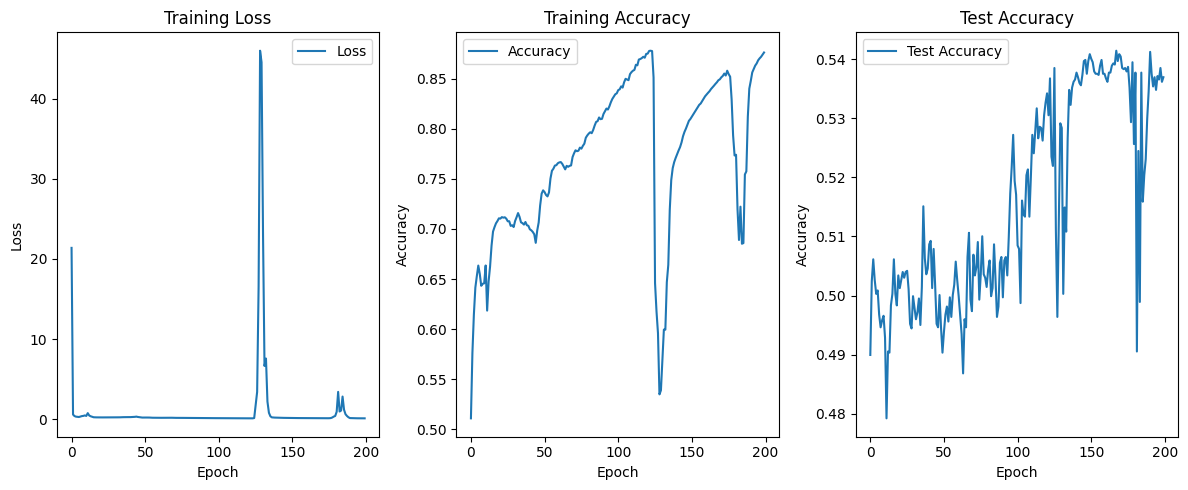

In [51]:
import torch
import torch.nn.functional as F
import tqdm
import matplotlib.pyplot as plt

optim = torch.optim.Adam([
    *deepfm.parameters(),
    *user_embedding_table.parameters()
], lr=0.001)

loss_type = "mse"
reward_rating_cutoff = 7

avg_reward_per_movie_numer = torch.zeros(len(train_movie_ids), device=device)
avg_reward_per_movie_denom = torch.zeros(len(train_movie_ids), device=device)

indexes = torch.randperm(len(train_ratings))
batch_size = 512

# Lists to store metrics for plotting
epoch_losses = []
epoch_accuracies = []
epoch_baseline_accuracies = []
epoch_test_accuracies = []

for epoch in range(200):
    epoch_loss_total = 0
    epoch_corrects = 0
    epoch_correct_baseline = 0
    epoch_seen = 0
    with tqdm.tqdm(range(0, len(indexes), batch_size)) as pbar:
        for batch_start in pbar:
            batch = train_ratings.iloc[indexes[batch_start:batch_start + batch_size]]

            movie_slugs = [str(x) for x in batch['movie_id'].values]
            train_user_ids = batch['user_id'].values
            ratings_ = batch['rating_val'].values

            user_indices = torch.tensor([user_id_to_index[user_id] for user_id in train_user_ids], device=device)
            user_vectors = user_embedding_table(user_indices)
            movie_vectors = movie_metadata_table(movie_slugs).to(device)
            movie_average_ratings = movie_vectors[:, 2].to(device)

            if movie_vectors.isnan().any():
                isnan_mask = movie_vectors.isnan().any(dim=-1)
                print(movie_vectors[isnan_mask])

            predictions = deepfm(movie_vectors.float(), user_vectors.float()).squeeze(-1)
            rewards = torch.tensor(ratings_ >= reward_rating_cutoff, device=device, dtype=torch.float32)

            assert not torch.any(rewards.isnan())

            if loss_type == 'mse':
                loss = F.mse_loss(predictions, rewards)
            elif loss_type == 'binary_crossentropy':
                loss = F.binary_cross_entropy_with_logits(predictions, rewards.float())

            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_corrects += ((predictions >= 0.5) == rewards).sum()

            movie_pos_in_tracking_vector = [train_movie_ids.index(slug) for slug in movie_slugs]
            avg_reward_per_movie_numer[movie_pos_in_tracking_vector] += rewards
            avg_reward_per_movie_denom[movie_pos_in_tracking_vector] += 1
            baseline_reward_predictions = (avg_reward_per_movie_numer/avg_reward_per_movie_denom)[movie_pos_in_tracking_vector]
            baseline_corrects = (baseline_reward_predictions >= 0.5) == rewards
            epoch_correct_baseline += baseline_corrects.sum()
            epoch_loss_total += loss.item() * len(user_indices)
            epoch_seen += len(user_indices)

            pbar.set_postfix(epoch=epoch, loss=epoch_loss_total / epoch_seen, accuracy=(epoch_corrects / epoch_seen).item(), baseline=(epoch_correct_baseline / epoch_seen).item())
    
    # Store metrics after each epoch
    epoch_losses.append(epoch_loss_total / epoch_seen)
    epoch_accuracies.append((epoch_corrects / epoch_seen).item())
    epoch_baseline_accuracies.append((epoch_correct_baseline / epoch_seen).item())

    test_accuracy = calculate_accuracy(test_ratings, user_embedding_table, movie_metadata_table, deepfm, user_id_to_index, device)
    epoch_test_accuracies.append(test_accuracy)
    if epoch in [49, 99, 199]:
        # test_accuracy = calculate_accuracy(test_ratings, user_embedding_table, movie_metadata_table, deepfm, user_id_to_index, device)
        print(f"Epoch {epoch}, Test accuracy: {test_accuracy}")

# Plotting the learning curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epoch_losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epoch_accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epoch_test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
